<a href="https://colab.research.google.com/github/uluumy/Fondements-de-l-apprentissage-profond/blob/master/RNN_LSTM_Classification_Critiques_de_films.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labo: Analyse des sentiments, Données de type texte

Dans ce labo, nous allons aborder un problème de classification binaire en utilisant des données textuelles, en occurrence les critiques de films.
L'objetif est de créer un modèle permettant de classer la critique du film en 2 catégories: positif et négatif.

Nous commencerons par utiliser un réseau de neurones fully connected.

Par la suite nous construirons un réseau de neurones de type RNN (avec LSTM)


##Étape 1: Mise en place de l'environnement

### Installer la version 1.16.2 de numpy
A la date de création de ce labo (19-05-2019), une erreur dans le load_data est apparue avec la version actuelle de numpy (1.16.3).
L'utilisation de la version précédente de numpy 1.16.2 permet de résoudre le problème

In [2]:
!pip install numpy==1.16.2
import numpy as np
print(np.version)

<module 'numpy.version' from '/usr/local/lib/python3.6/dist-packages/numpy/version.py'>


In [3]:
np.__version__

'1.16.2'

### Librairies à importer

In [4]:
#import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.datasets import imdb

keras.__version__

Using TensorFlow backend.


'2.2.4'

### Des fonctions utiles

In [0]:
def plot_history(x,y1,y2,y1_label, y2_label, x_label, y_label,title):
  plt.clf()
  plt.plot(x, y1, 'bo', label=y1_label) # 'bo' pour "blue dot"
  plt.plot(x, y2, 'b', label=y2_label) # 'b' pour "solid blue line"
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show

##Étape 2: Obtention des données: le Dataset IMDB

### Le Dataset IMDB
IMDB est un jeu de données de 50 000 critiques de films, étiquetés par sentiment (positif/négatif). 

Le dataset est divisé en 25,000 observations d'entrainement et 25,000 de test. Chaque ensemble consistant en 50% de critiques négatives et 50% de critiques positives.

Les commentaires ont été pré-traités, et chaque critique est encodé sous la forme d'une séquence d'index de mots (entiers). 

Pour plus de commodité, les mots sont indexés par fréquence globale dans le DataSet, de sorte que, par exemple, l'entier "3 " encode le troisième mot le plus fréquent dans les données. Cela permet des opérations de filtrage rapide telles que: "seulement considérer le Top 10 000 les mots les plus courants".

Par convention, "0 " ne représente pas un mot spécifique, mais est utilisé pour coder n'importe quel mot inconnu.




---


IMDB est intégrée dans Keras. Le dataset a été déjà préparée. Donc c'est un dataset de choix pour commencer a créer rapidement des modèles de classification.


Commencant par charger le dataset.

### Chargement

In [6]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


L'argument num_words=10000 veut dire que nous allons garder que le top 10.000 mots les plus fréquents dans le dataset

In [0]:
# le format du dataset de training
train_data.shape

(25000,)

In [0]:
# Regardons un exemple
train_data[0]

In [0]:
max([max(sequence) for sequence in train_data])

9999

Faisons le mapping inverse : de l'indexe vers la critique

In [0]:
def decode_review(index):
  # word_index est un dictionnaire qui fait le 'mapping' du mot vers l'indice (de type entier)
  word_index = imdb.get_word_index()
  # on l'inverse en faisant le 'mapping' indices à mot
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  # et on décode le 'review'. À remarque que les indices sont sont décalés de 3 parce que 0, 1 et 2 sont des indices réservés pour "padding", "start of sequence" et "unknown"
  decode_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[index]])
  return decode_review


In [0]:
decode_review(2)

"? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

### Préparation des données

Transformation de la liste d'entiers en tensor.
On utilise la transformation *one-hot-encode*

In [0]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences),dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  return results

In [0]:

# Expliquer la fonction avec un exemple simple
#results = np.zeros((2,10))
#for i, sequence in enumerate(train_data):
#  results[i, sequence] = 1
#  print(i)
#  print(sequence)
#  if i > 0: break
#print(results[0])

#results[0,[1,3]] = 1
#print(results[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]


In [0]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [0]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [0]:
x_train.shape

(25000, 10000)

La Vectorisation des labels est plus simple...

In [0]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Étape 3: Définition de l'architecture du modèle
Dans ce labo nous allons utiliser un resau de neurones fully connected

In [0]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=0.01),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Étape 4: Entrainement du modèle
Creation d'un dataset de validation

In [0]:
x_val = x_train[:5000]
partial_x_train = x_train[5000:]

y_val = y_train[:5000]
partial_y_train = y_train[5000:]

On peut maintenant entrainer le model

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.5176 - binary_accuracy: 0.7674 - val_loss: 0.3063 - val_binary_accuracy: 0.8730
Epoch 2/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.2512 - binary_accuracy: 0.8993 - val_loss: 0.3754 - val_binary_accuracy: 0.8592
Epoch 3/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.1947 - binary_accuracy: 0.9233 - val_loss: 0.3589 - val_binary_accuracy: 0.8754
Epoch 4/20
20000/20000 [==============================] - 3s 142us/step - loss: 0.1493 - binary_accuracy: 0.9376 - val_loss: 0.3278 - val_binary_accuracy: 0.8852
Epoch 5/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.1041 - binary_accuracy: 0.9595 - val_loss: 0.4193 - val_binary_accuracy: 0.8834
Epoch 6/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.1172 - bina

## Étape 5: Évaluation du modèle

In [0]:
history_dict = history.history
history_dict.keys()

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1,len(acc)+1)

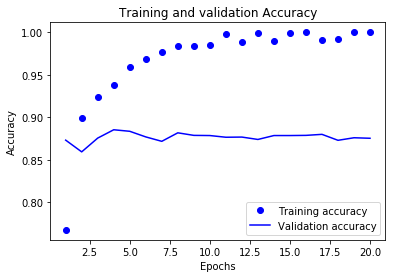

In [0]:
plot_history(epochs, acc, val_acc, 'Training accuracy', 'Validation accuracy', 'Epochs', 'Accuracy','Training and validation Accuracy')

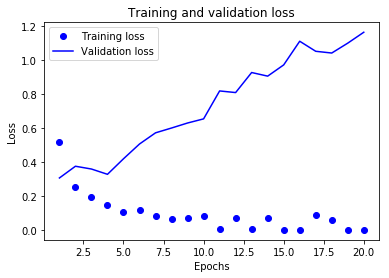

In [0]:
plot_history(epochs, loss, val_loss, 'Training loss', 'Validation loss', 'Epochs', 'Loss','Training and validation loss')

In [0]:
results = model.evaluate(x_test, y_test)
print('test accuracy:', results[1])

25000/25000 [==============================] - 2s 95us/step
test accuracy: 0.85716


In [0]:
print('train accuracy:', model.evaluate(x_train, y_train)[1])

25000/25000 [==============================] - 5s 190us/step
train accuracy: 0.975


Nous avons un probleme de sur-apprentissage.
Essayer d'ajouter de la regularisation L2

## Étape 5: Regularisation

In [0]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                       input_shape=(x_train.shape[1],)))
l2_model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
l2_model.add(layers.Dense(1, activation='sigmoid'))

l2_model.compile(optimizer = 'rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

l2_history = l2_model.fit(partial_x_train,
                          partial_y_train,
                          epochs=20,
                          batch_size=512,
                          validation_data=(x_val, y_val)
                         )

l2_results = l2_model.evaluate(x_test, y_test)
print('l2 model test accuracy:', l2_results[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 164us/step - loss: 2.2887 - acc: 0.7582 - val_loss: 1.7373 - val_acc: 0.8204
Epoch 2/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.5782 - acc: 0.8264 - val_loss: 1.4561 - val_acc: 0.7436
Epoch 3/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.3118 - acc: 0.8243 - val_loss: 1.1984 - val_acc: 0.8308
Epoch 4/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.1022 - acc: 0.8187 - val_loss: 1.0573 - val_acc: 0.7236
Epoch 5/20
20000/20000 [==============================] - 3s 145us/step - loss: 0.9432 - acc: 0.8203 - val_loss: 0.9002 - val_acc: 0.7698
Epoch 6/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.8271 - acc: 0.8198 - val_loss: 0.8096 - val_acc: 0.7586
Epoch 7/20
20000/20000 [==============================] - 3s 144us/step - loss: 0.7451 - acc: 0.8263 - val_loss: 0.7154 - v

In [0]:
print('l2 train accuracy:', l2_model.evaluate(x_train, y_train)[1])

results = l2_model.evaluate(x_test, y_test)
print('test accuracy:', results[1])

25000/25000 [==============================] - 3s 115us/step
l2 train accuracy: 0.82088
25000/25000 [==============================] - 3s 111us/step
test accuracy: 0.80648


**Predictions**

In [0]:
model.predict(x_test)

array([[0.21604328],
       [0.9997979 ],
       [0.9381573 ],
       ...,
       [0.13183375],
       [0.05760219],
       [0.6786002 ]], dtype=float32)

## Étape 7: Modele recurrent: LSTM

In [12]:
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [14]:
from keras.layers import LSTM

lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(max_features, 32))
lstm_model.add(layers.LSTM(16))
lstm_model.add(layers.Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2)


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.6406 - acc: 0.6645 - val_loss: 0.5254 - val_acc: 0.7932
Epoch 2/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.4505 - acc: 0.8260 - val_loss: 0.4133 - val_acc: 0.8444
Epoch 3/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3583 - acc: 0.8710 - val_loss: 0.4366 - val_acc: 0.8088
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3024 - acc: 0.8940 - val_loss: 0.3350 - val_acc: 0.8708
Epoch 5/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2598 - acc: 0.9098 - val_loss: 0.4156 - val_acc: 0.8138
Epoch 6/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2341 - acc: 0.9186 - val_loss: 0.3640 - val_acc: 0.8494
Epoch 7/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2113 - acc: 0.9268 - val_loss: 0.3654 - val_acc:

In [15]:
lstm_results = lstm_model.evaluate(input_test, y_test)
print('l2 model test accuracy:', lstm_results[1])

25000/25000 [==============================] - 100s 4ms/step
l2 model test accuracy: 0.86092
